In [1]:
import sys
sys.path.insert(0, '../')
import ccob_qe_analysis_BOT as ana
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import numpy as np
from lsst.obs.lsst.cameraTransforms import LsstCameraTransforms
from lsst.obs.lsst import LsstCamMapper as camMapper
import os

In [2]:
camera = camMapper._makeCamera()
lct = LsstCameraTransforms(camera)
basedir1 = '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/'
basedir2 = '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/'

path_to_data = {'R01': basedir1 + '6848D/BOT_acq/v0/48087/',
                'R02': basedir1 + '6849D/BOT_acq/v0/48093/',
                'R10': None,
                'R11': basedir1 + '6851D/BOT_acq/v0/48108/',
                'R12': basedir1 + '6852D/BOT_acq/v0/48113/',
                'R20': basedir1 + '6853D/BOT_acq/v0/48118/',
                'R21': None,
                'R22': basedir2 + '11974/BOT_acq/v0/93868/',
                'R30': basedir1 + '6843D/BOT_acq/v0/48047/'
               }
path_to_beam = '/home/combet/tmp_9rafts/60x60/'

path_to_bias = '/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_Bias/Run3'
#outdir_figs = '/home/combet/tmp_9rafts/QE_results_PTC/'
outdir_figs = '/home/combet/tmp_9rafts/QE_results_w_biasfile/'
#outdir_fits = '/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE_PTC/'
outdir_fits = '/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE_w_biasfile/'

led_beam = 'red'
led = 'red'

model_ccdid = 'R22_S11'
beam_model = ana.load_beam_model(path_to_beam, led_name=led_beam, ref_amp=5, ccdid=model_ccdid)
delta_x, delta_y = ana.compute_offsets(beam_model, lct, ccdid=model_ccdid, ref_pix_x=2304, ref_pix_y=3003)

#raft_list = ['R12','R20', 'R22','R30']
#raft_list = ['R01','R02','R11','R12','R20', 'R22','R30']
raft_list = ['R30']
#sensor_list = ['S00','S01','S02','S10','S11','S12','S20','S21','S22']
sensor_list = ['S00']

ccdid_list = sorted([raft+'_'+sensor for sensor in sensor_list for raft in raft_list])

for data_ccdid in ccdid_list[0:1]:
#Fe55 gains
    gainfile = '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6801D/fe55_analysis_BOT/v0/47706/'+data_ccdid+'_6801D_eotest_results.fits'

# PTC gains
#    gainfile = '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/12398/ptc_BOT/v0/97787/'+data_ccdid+'_12398_eotest_results.fits'
    biasfile = os.path.join(path_to_bias,f'{data_ccdid}_sbias.fits')
    raft = data_ccdid.split('_')[0]
    data = ana.qe_data.CcobQeData(data_ccdid, led, path_to_data[raft], gainfile, biasfile=biasfile, is_PTC=False)
    data.find_dir()
    
    for pos in data.pos_list:
        data.make_avg_mosaic_at_pos(pos, '/home/combet/tmp_9rafts/')
        mosaic = data.data[pos]['mosaic']
        bbox = ana.define_model_bbox(beam_model, mosaic, data.lct, pos, delta_x, delta_y)

        xarr = np.linspace(bbox[0],bbox[1],mosaic.shape[0])
        yarr = np.linspace(bbox[2],bbox[3],mosaic.shape[1])
        tmp = beam_model.beam_image['f_interp'](xarr, yarr) # interp works in cam coordinates
        tmp = np.flip(np.flip(tmp,axis=0),axis=1) # invert the model in x and in y 
        model_eotestDef = np.flip(tmp.T, axis=1) # beam model following EOTest convention
        model_normalised = model_eotestDef/np.max(model_eotestDef.flatten())
        qe = mosaic/model_normalised
#        qe = mosaic/model_eotestDef
        qe_norm = qe / np.median(qe.flatten())

        outfile = outdir_fits+'fits/QE_'+data_ccdid+'_'+led+'_'+pos+'.fits'
        amp_coord = data.data[pos]['amp_coord']
        ana.make_fits(qe,amp_coord, outfile, data.template_file)

#        figfile = outdir_figs+'figs/QE_'+data_ccdid+'_'+led+'_'+pos+'_from_'+led_beam+'_norm.png'
        figfile = outdir_figs+'figs/QE_'+data_ccdid+'_'+led+'_'+pos+'_norm.png'
        ana.plot_results(qe_norm, model_normalised, mosaic, data_ccdid, data.lct, pos, delta_x, delta_y,figfile)



/home/combet/tmp_9rafts/60x60/beam_object_R22_S11_red_on.pkl


In [ ]:
data.pos_list

In [ ]:
import lsst.eotest.sensor as sensorTest
import lsst.eotest.raft as eotest_raft
import lsst.eotest.image_utils as imutils
from lsst.eotest.sensor.EOTestPlots import cmap_range
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
def plot(dd, title=None, cmap=plt.cm.hot, nsig=5, figsize=(10, 10),
             binsize=10, flipx=True, textcolor='c', annotation='',
             rotate180=False):
        """
        Render the raft mosaic.
        Parameters
        ----------
        title : str, optional
            The plot title. If None (default), then build the title
            from the RAFTNAME and MONOWL primary header keyword values.
        cmap : matplotlib.colors.Colormap, optional
            The color map to use. Default: matplotlib.pyplot.cm.hot.
        nsig : float, optional
            The n-sigma value for the sigma clipping used to determine
            the pixel value range over which the color map is mapped.
        figsize : (float, float), optional
            The width x height size of the figure in inches. Default: (10, 10).
        binsize : int, optional
            Rebin the plotted image data by binsize*binsize,
            averging over the coarser bin.  Default: 10
        flipx : bool, optional
            Flip full raft mosaic in x so that parity of image matches
            LCA-13381. Default: True
        textcolor : str, optional
            Color of the text for the segment and sensor labeling.
            Default: 'c' (cyan)
        annotation : str, optional
            Description of the plot, e.g., pixel units (ADU or e-),
            gain-corrected, bias-subtracted.  Default: ''
        rotate180 : bool [False]
            Flag to rotate the mosaic by 180 degrees to match the
            orientation of the focalplane mosiacs created for the
            BOT-level plots.
        """
        plt.rcParams['figure.figsize'] = figsize
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        output_array = imutils.rebin_array(dd.image_array, binsize,
                                           use_mean=True)
        if flipx:
            output_array = output_array[:, ::-1]
        if rotate180:
            ny, nx = output_array.shape
            rotated_array = np.zeros((nx, ny), dtype=output_array.dtype)
            for j in range(ny):
                rotated_array[:, ny-1-j] = output_array[::-1, j]
            output_array = rotated_array
        image = ax.imshow(output_array, interpolation='nearest', cmap=cmap)
        # Set range and normalization of color map based on sigma-clip
        # of pixel values.
        vmin, vmax = cmap_range(output_array, nsig=nsig)
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        image.set_norm(norm)
        if title is None:
            title = "%s, %i nm" % (dd.raft_name, dd.wl)
        ax.set_title(title)
        fig.colorbar(image)
        # Turn off ticks and tick labels for x- and y-axes.
        plt.tick_params(axis='both', which='both',
                        top='off', bottom='off', left='off', right='off',
                        labelbottom='off', labelleft='off')
        # Label segments by sensor bay and segment number.
        for slot in dd.fits_files:
            seg_coords = list(dd._amp_coords[slot].values())[-8]
            xmin, xmax, ymin, ymax = seg_coords
            xx = float(xmax + xmin)/2./float(dd.nx)
            if flipx:
                xx = 1 - xx
            yy = 1. - (float(ymax - ymin)*0.05 + ymin)/float(dd.ny)
            if rotate180:
                xx = 1 - xx - 7*np.abs(xmax - xmin)/float(dd.nx)
                yy = 1 - yy + 1.9*np.abs(ymax - ymin)/float(dd.ny)
            plt.annotate('%s' % slot,
                         (xx, yy), xycoords='axes fraction',
                         size='x-small', horizontalalignment='center',
                         verticalalignment='center', color=textcolor)
            for amp, seg_coords in list(dd._amp_coords[slot].items()):
                xmin, xmax, ymin, ymax = seg_coords
                xx = float(xmax + xmin)/2./float(dd.nx)
                if flipx:
                    xx = 1. - xx
                if amp <= 8:
                    yy = 1. - (float(ymax - ymin)*0.85 + ymin)/float(dd.ny)
                else:
                    yy = 1. - (float(ymax - ymin)*0.15 + ymin)/float(dd.ny)
                if rotate180:
                    xx = 1 - xx
                    yy = 1 - yy
                plt.annotate('%s' % imutils.channelIds[amp],
                             (xx, yy), xycoords='axes fraction',
                             size='x-small', horizontalalignment='center',
                             verticalalignment='center', color=textcolor)
        plt.annotate(annotation, (1, -0.1), xycoords='axes fraction',
                     horizontalalignment='right', verticalalignment='bottom')
        return fig

In [ ]:
raft = 'R22'
slot_names=['S00','S01','S02','S10','S11','S12','S20','S21','S22']
led = 'blue'
#slot = slot_names[0]
#sorted(glob.glob(f'/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_{raft}_{slot}_{led}*'))[2]
#[(glob.glob(f'/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_{raft}_{slot}_{led}*')[2])[0] for slot in slot_names]
fits_files_dict ={slot : sorted(glob.glob(f'/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_{raft}_{slot}_{led}*'))[2] for slot in slot_names}
fits_files_dict

In [ ]:
dd = eotest_raft.RaftMosaic(fits_files_dict)

In [ ]:
raft_name = dd.raft_name.split('_')[1]

In [ ]:
tmp = plot(dd,rotate180=True, nsig=4, title=f'CCOB composite flat - {led} - {raft} ({raft_name})')

In [ ]:
outdir_figs = '/home/combet/tmp_9rafts/QE_results/figs/'
tmp.savefig(outdir_figs+f'{raft}_flat_{led}.png')

In [5]:
from astropy.io import fits as fits

In [7]:
hdu = fits.open('/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S00_blue_-286.285_-32.685.fits')

In [12]:
hdu[0].header

SIMPLE  =                    T / Java FITS: Mon Oct 28 17:54:09 PDT 2019        
BITPIX  =                    8 / bits per data value                            
NAXIS   =                    0 / number of axes                                 
EXTEND  =                    T / Extensions are permitted                       
DATE    = '2019-10-29T02:27:48.545' / Creation Date and Time of File            
DATE-OBS= '2019-10-29T02:27:46.151' / Date of the image trigger (readout), UTC f
MJD     =    58785.10264519695 / Modified Julian Date that the file was written 
MJD-OBS =    58785.10261748824 / Modified Julian Date of image trigger          
RUNNUM  = '6852D   '           / The Run Number                                 
IMAGETAG= 'd9b96a33ead3fba4'   / DAQ Image id (Hex)                             
TSTAND  = 'BOT     '           / Camera test stand BOT or CCOB                  
INSTRUME= 'lsstCam '           / Instrument                                     
CONTNUM = '18ee34d8'        

In [3]:
import ccob_utils as u
f1 = '/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R22_S11_red_0.005_0.005.fits'
im, dum = u.make_ccd_2d_array(f1)

In [ ]:
f2 = '/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R22_S11_red_10.015_-10.235.fits'
im2, dum = u.make_ccd_2d_array(f2)

In [ ]:
import scipy
#residuals = (im-im2)*100/im
residuals = scipy.ndimage.filters.gaussian_filter((im-im2)/im, 1, mode='constant')
plt.imshow(residuals, vmin=-0.002, vmax=0.002)
plt.colorbar()

In [9]:
f = '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6852D/BOT_acq/v0/48113/ccob_nm960_-159.175_-32.325_006/MC_C_20191028_005273_R12_S00.fits'

hdu = fits.open(f)

In [10]:
hdu[0].header

SIMPLE  =                    T / Java FITS: Mon Oct 28 17:54:09 PDT 2019        
BITPIX  =                    8 / bits per data value                            
NAXIS   =                    0 / number of axes                                 
EXTEND  =                    T / Extensions are permitted                       
DATE    = '2019-10-29T02:27:48.545' / Creation Date and Time of File            
DATE-OBS= '2019-10-29T02:27:46.151' / Date of the image trigger (readout), UTC f
MJD     =    58785.10264519695 / Modified Julian Date that the file was written 
MJD-OBS =    58785.10261748824 / Modified Julian Date of image trigger          
RUNNUM  = '6852D   '           / The Run Number                                 
IMAGETAG= 'd9b96a33ead3fba4'   / DAQ Image id (Hex)                             
TSTAND  = 'BOT     '           / Camera test stand BOT or CCOB                  
INSTRUME= 'lsstCam '           / Instrument                                     
CONTNUM = '18ee34d8'        

In [40]:
gainfile = '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/12398/ptc_BOT/v0/97787/R22_S11_12398_eotest_results.fits'
hdu = fits.open(gainfile)

NameError: name 'fits' is not defined

In [14]:
hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   78 / length of dimension 1                          
NAXIS2  =                   16 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'AMP     '                                                            
TFORM1  = 'I       '                                                            
TUNIT1  = 'None    '                                                            
TTYPE2  = 'GAIN    '                                                            
TFORM2  = 'E       '        

In [41]:
import ccob_utils as u

In [42]:
ptc = u.gains(gainfile, is_PTC=True)
ptc

{1: 1.0552812,
 2: 1.0597286,
 3: 1.0707808,
 4: 1.065923,
 5: 1.0722777,
 6: 1.0782045,
 7: 1.0769361,
 8: 1.0746137,
 9: 1.0385566,
 10: 1.0469084,
 11: 1.04641,
 12: 1.0496937,
 13: 1.0442042,
 14: 1.0483345,
 15: 1.0481669,
 16: 1.0335327}

In [43]:
gainfile = '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6801D/fe55_analysis_BOT/v0/47706/'+data_ccdid+'_6801D_eotest_results.fits'
fe55 = u.gains(gainfile, is_PTC=False)
[fe55[k] for k in fe55]

[1.0455476,
 1.0528271,
 1.0641745,
 1.0611658,
 1.0676948,
 1.0666254,
 1.0660648,
 1.0650551,
 1.0287825,
 1.0381801,
 1.036997,
 1.0418969,
 1.0387852,
 1.0402898,
 1.0385242,
 1.0272291]

Text(0.5, 1.0, 'R22_S11')

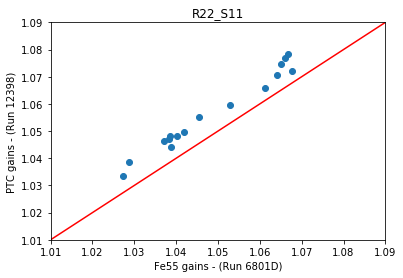

In [44]:
fe55_gains = [fe55[k] for k in fe55]
ptc_gains = [ptc[k] for k in ptc]
plt.scatter(fe55_gains, ptc_gains)
plt.plot([1.01, 1.09],[1.01,1.09], 'r')
plt.xlim([1.01,1.09])
plt.ylim([1.01,1.09])
plt.xlabel('Fe55 gains - (Run 6801D)')
plt.ylabel('PTC gains - (Run 12398)')
plt.title('R22_S11')

In [11]:
%ls /gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE_w_biasfile/fits

QE_R02_S21_red_-201.815_-10.575.fits  QE_R02_S21_red_-221.815_-10.575.fits
QE_R02_S21_red_-201.815_9.785.fits    QE_R02_S21_red_-221.815_9.785.fits
QE_R02_S21_red_-211.815_-0.395.fits


In [24]:
f = '/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE_w_biasfile/fits/QE_R02_S21_red_-211.815_-0.395.fits'

In [25]:
import ccob_utils as u
mosaic1, amp_coords = u.make_ccd_2d_array(f)

/gpfs/slac/lsst/fs3/g/software/stack/v20.0.0/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.FileIO name='/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE_w_biasfile/fits/QE_R02_S21_red_-211.815_-0.395.fits' mode='rb' closefd=True>
  


In [26]:
f = '/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-211.815_-0.395.fits'
mosaic2, amp_coords = u.make_ccd_2d_array(f)

/gpfs/slac/lsst/fs3/g/software/stack/v20.0.0/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.FileIO name='/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-211.815_-0.395.fits' mode='rb' closefd=True>
  


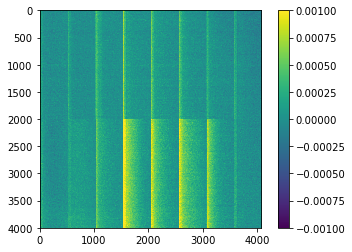

In [47]:
plt.imshow((mosaic2-mosaic1)/mosaic2, vmin=-0.001, vmax=0.001)
plt.colorbar()

In [48]:
f = '/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE_w_biasfile/fits/QE_R22_S11_red_0.005_0.005.fits'
mosaic3, amp_coords = u.make_ccd_2d_array(f)

/gpfs/slac/lsst/fs3/g/software/stack/v20.0.0/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.FileIO name='/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE_w_biasfile/fits/QE_R22_S11_red_0.005_0.005.fits' mode='rb' closefd=True>
  


In [49]:
f = '/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R22_S11_red_0.005_0.005.fits'
mosaic4, amp_coords = u.make_ccd_2d_array(f)

/gpfs/slac/lsst/fs3/g/software/stack/v20.0.0/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.FileIO name='/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R22_S11_red_0.005_0.005.fits' mode='rb' closefd=True>
  


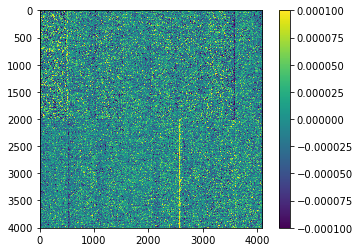

In [50]:
plt.imshow((mosaic3-mosaic4)/mosaic4, vmin=-0.0001, vmax=0.0001)
plt.colorbar()

In [55]:
beam_model.properties

{'ref_raft': 'R22',
 'ref_slot': 'S11',
 'ref_amp': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 'ref_pix_x': 1000,
 'ref_pix_y': 256,
 'npix_for_avg': 30,
 'analysis_amp': 5,
 'ncols': 300,
 'nrows': 300,
 'max_xccob': 14.964832775919731,
 'max_yccob': -4.525301003344488,
 'max_xarg': 168,
 'max_yarg': 123}